In [6]:
import pandas as pd
import numpy as np
import time
import os
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report,roc_auc_score,precision_recall_fscore_support,f1_score)

df = pd.read_csv("data/processed/stroke_processed.csv")

X = df.drop("stroke", axis=1)
y = df["stroke"]

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,
    stratify=y_temp,
    random_state=42
)


In [4]:
base_rf = RandomForestClassifier(
    class_weight="balanced",
    random_state=42,
    n_jobs=1
)

param_grid = [
    {"n_estimators": 100, "max_depth": None, "min_samples_split": 2,
     "min_samples_leaf": 1, "max_features": "sqrt"},
    {"n_estimators": 200, "max_depth": 10, "min_samples_split": 2,
     "min_samples_leaf": 1, "max_features": "sqrt"},
    {"n_estimators": 200, "max_depth": 10, "min_samples_split": 5,
     "min_samples_leaf": 2, "max_features": "sqrt"},
    {"n_estimators": 300, "max_depth": 20, "min_samples_split": 2,
     "min_samples_leaf": 1, "max_features": 0.5},
]

best_f1 = -np.inf
best_params = None
best_rf = None
train_time_rf = None
inference_time_rf = None

for params in param_grid:
    print("Training with params:", params)
    rf = base_rf.set_params(**params)

    start = time.perf_counter()
    rf.fit(X_train, y_train)
    train_time = time.perf_counter() - start

    start = time.perf_counter()
    y_val_pred = rf.predict(X_val)
    y_val_proba = rf.predict_proba(X_val)[:, 1]
    inf_time = time.perf_counter() - start

    f1 = f1_score(y_val, y_val_pred, pos_label=1)
    roc_auc = roc_auc_score(y_val, y_val_proba)
    print(f"Val F1: {f1:.4f}, ROC-AUC: {roc_auc:.4f}\n")

    if f1 > best_f1:
        best_f1 = f1
        best_params = params
        best_rf = rf
        train_time_rf = train_time
        inference_time_rf = inf_time

print("Best params:", best_params)
print(f"Best validation F1: {best_f1:.4f}")

print("\nValidation report for best RF:")
y_val_pred_rf = best_rf.predict(X_val)
y_val_proba_rf = best_rf.predict_proba(X_val)[:, 1]
print(classification_report(y_val, y_val_pred_rf, digits=4))

roc_auc_rf = roc_auc_score(y_val, y_val_proba_rf)
print("Validation ROC-AUC (RF):", roc_auc_rf)


Training with params: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Val F1: 0.0385, ROC-AUC: 0.7824

Training with params: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Val F1: 0.1053, ROC-AUC: 0.8028

Training with params: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}
Val F1: 0.1220, ROC-AUC: 0.8210

Training with params: {'n_estimators': 300, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5}
Val F1: 0.0000, ROC-AUC: 0.8109

Best params: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}
Best validation F1: 0.1220

Validation report for best RF:
              precision    recall  f1-score   support

           0     0.9510    0.9990    0.9744       972
           1     0.0000    0.0000    0.0000       

Here I train several Random Forest models using a small manual hyperparameter grid. This lightweight search avoids memory issues while still allowing me to find a well-performing model. The model with the best validation F1 score is selected as best_rf.

In [10]:
for t in [0.50, 0.35, 0.30, 0.25, 0.20, 0.15, 0.10]:
    preds = (y_val_proba_rf >= t).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_val, preds, average="binary", pos_label=1
    )
    print(f"t={t:.2f} | Precision={precision:.3f}  Recall={recall:.3f}  F1={f1:.3f}")

t=0.50 | Precision=0.000  Recall=0.000  F1=0.000
t=0.35 | Precision=0.200  Recall=0.040  F1=0.067
t=0.30 | Precision=0.214  Recall=0.060  F1=0.094
t=0.25 | Precision=0.154  Recall=0.080  F1=0.105
t=0.20 | Precision=0.145  Recall=0.180  F1=0.161
t=0.15 | Precision=0.141  Recall=0.280  F1=0.188
t=0.10 | Precision=0.137  Recall=0.480  F1=0.213


This cell evaluates the model across different probability thresholds to see how precision, recall, and F1 score change. Lower thresholds often improve recall on imbalanced datasets like this one. The results help choose a better threshold than the default 0.50.

In [11]:
start = time.perf_counter()
y_val_pred_raw = best_rf.predict(X_val)  
y_val_proba_rf = best_rf.predict_proba(X_val)[:, 1]
inference_time_rf = time.perf_counter() - start 

threshold_rf = 0.10   
y_val_pred_rf = (y_val_proba_rf >= threshold_rf).astype(int)

print("Random Forest (Validation with threshold 0.25):")
print(classification_report(y_val, y_val_pred_rf, digits=4, zero_division=0))

rf_precision, rf_recall, rf_f1, _ = precision_recall_fscore_support(
    y_val, y_val_pred_rf, average="binary", pos_label=1
)
rf_roc_auc = roc_auc_score(y_val, y_val_proba_rf)

rf_results_df = pd.DataFrame([{
    "Model": "Random Forest",
    "Train_time": train_time_rf,
    "Inference_time": inference_time_rf,
    "Precision": rf_precision,
    "Recall": rf_recall,
    "F1": rf_f1,
    "ROC_AUC": rf_roc_auc
}])

os.makedirs("results", exist_ok=True)

rf_results_df.to_csv("results/random_forest_metrics.csv", index=False)
rf_results_df



Random Forest (Validation with threshold 0.25):
              precision    recall  f1-score   support

           0     0.9693    0.8447    0.9027       972
           1     0.1371    0.4800    0.2133        50

    accuracy                         0.8268      1022
   macro avg     0.5532    0.6623    0.5580      1022
weighted avg     0.9286    0.8268    0.8690      1022



,Model,Train_time,Inference_time,Precision,Recall,F1,ROC_AUC
0,Random Forest,0.410345,0.057177,0.137143,0.48,0.213333,0.810864


Using the selected threshold, this cell computes the final validation precision, recall, F1 score, and ROC-AUC for the Random Forest. It also records inference time for later comparison. The metrics are saved to a CSV file for use in the model comparison stage.

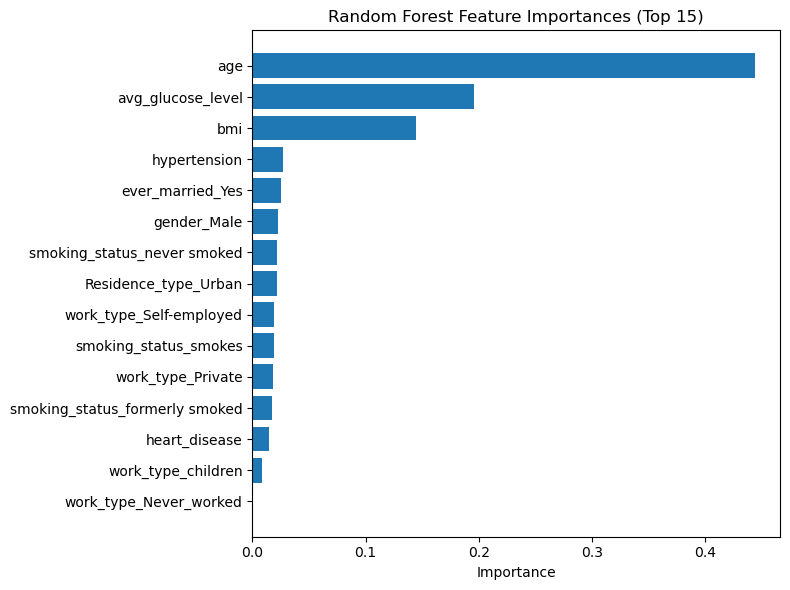

,feature,importance
0,age,4.438920e-01
3,avg_glucose_level,1.956671e-01
4,bmi,1.446771e-01
1,hypertension,2.715233e-02
7,ever_married_Yes,2.523468e-02
5,gender_Male,2.225389e-02
14,smoking_status_never smoked,2.192641e-02
12,Residence_type_Urban,2.168536e-02
10,work_type_Self-employed,1.930516e-02
15,smoking_status_smokes,1.884753e-02


In [9]:
import matplotlib.pyplot as plt

importances = best_rf.feature_importances_
feature_names = X.columns

feat_imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

top_k = 15
plt.figure(figsize=(8, 6))
plt.barh(feat_imp_df["feature"].head(top_k)[::-1],
         feat_imp_df["importance"].head(top_k)[::-1])
plt.xlabel("Importance")
plt.title("Random Forest Feature Importances (Top 15)")
plt.tight_layout()
plt.show()

feat_imp_df.head(20)


This cell visualizes which features the Random Forest considers most important for predicting stroke. Feature importance helps interpret the model and understand which variables influence decisions most. This is required for the model interpretation section of the project.

In [12]:
y_test_proba_rf = best_rf.predict_proba(X_test)[:, 1]
y_test_pred_rf = (y_test_proba_rf >= threshold_rf).astype(int)

print(f"Random Forest – TEST SET (threshold = {threshold_rf})")
print(classification_report(y_test, y_test_pred_rf, digits=4, zero_division=0))

test_roc_auc_rf = roc_auc_score(y_test, y_test_proba_rf)
print("Test ROC-AUC:", test_roc_auc_rf)


Random Forest – TEST SET (threshold = 0.1)
              precision    recall  f1-score   support

           0     0.9711    0.8642    0.9145       972
           1     0.1592    0.5000    0.2415        50

    accuracy                         0.8464      1022
   macro avg     0.5652    0.6821    0.5780      1022
weighted avg     0.9314    0.8464    0.8816      1022

Test ROC-AUC: 0.8025


Here I evaluate the final model on the held-out test set using the same optimized threshold. The performance metrics reflect how well the model generalizes to unseen data. These results will be compared with the baseline and neural network models in the final analysis.